In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/accident-detection-from-cctv-footage/data/val/Non Accident/test7_1.jpg
/kaggle/input/accident-detection-from-cctv-footage/data/val/Non Accident/test4_14.jpg
/kaggle/input/accident-detection-from-cctv-footage/data/val/Non Accident/test15_18.jpg
/kaggle/input/accident-detection-from-cctv-footage/data/val/Non Accident/test15_27.jpg
/kaggle/input/accident-detection-from-cctv-footage/data/val/Non Accident/test8_23.jpg
/kaggle/input/accident-detection-from-cctv-footage/data/val/Non Accident/test28_14.jpg
/kaggle/input/accident-detection-from-cctv-footage/data/val/Non Accident/test25_5.jpg
/kaggle/input/accident-detection-from-cctv-footage/data/val/Non Accident/test29_18.jpg
/kaggle/input/accident-detection-from-cctv-footage/data/val/Non Accident/test8_24.jpg
/kaggle/input/accident-detection-from-cctv-footage/data/val/Non Accident/test4_21.jpg
/kaggle/input/accident-detection-from-cctv-footage/data/val/Non Accident/test_22.jpg
/kaggle/input/accident-detection-from-cctv-footage/d

In [2]:
import tensorflow as tf
import keras
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt

2024-07-12 01:45:08.764344: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-12 01:45:08.764506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-12 01:45:08.930734: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [16]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 25

In [18]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
"/kaggle/input/accident-detection-from-cctv-footage/data/train",
shuffle = "True",
image_size = (IMAGE_SIZE,IMAGE_SIZE),
batch_size = BATCH_SIZE
)

Found 791 files belonging to 2 classes.


In [19]:
class_names = train_ds.class_names
class_names

['Accident', 'Non Accident']

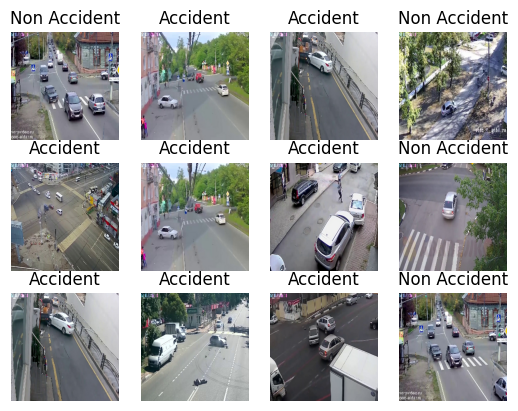

In [20]:
for image_batch,label_batch in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [21]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
"/kaggle/input/accident-detection-from-cctv-footage/data/test",
shuffle = "True",
image_size = (IMAGE_SIZE,IMAGE_SIZE),
batch_size = BATCH_SIZE
)

Found 100 files belonging to 2 classes.


In [22]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
"/kaggle/input/accident-detection-from-cctv-footage/data/val",
shuffle = "True",
image_size = (IMAGE_SIZE,IMAGE_SIZE),
batch_size = BATCH_SIZE
)

Found 98 files belonging to 2 classes.


In [23]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [24]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [25]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_verical"),
    layers.RandomRotation(0.2)
])

In [67]:
input_shape= (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(128, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'linear'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, kernel_size = (3,3), activation = 'linear'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'linear'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
])
model.build(input_shape=input_shape)

In [68]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (32, 254, 254, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (32, 127, 127, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (32, 125, 125, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (32, 60, 60, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (32, 30, 30, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (32, 28, 28, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (32, 14, 14, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (32, 12, 12, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (32, 4, 4, 128)        │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (32, 2, 2, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (32, 512)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (32, 512)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (32, 64)               │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (32, 1)                │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 230,337 (899.75 KB)

 Trainable params: 230,337 (899.75 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

In [70]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 147s 6s/step - accuracy: 0.4981 - loss: 0.6960 - val_accuracy: 0.5306 - val_loss: 0.6898
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - accuracy: 0.5221 - loss: 0.6915 - val_accuracy: 0.5306 - val_loss: 0.6956
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 143s 6s/step - accuracy: 0.5085 - loss: 0.6993 - val_accuracy: 0.5306 - val_loss: 0.6891
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 140s 6s/step - accuracy: 0.5457 - loss: 0.6914 - val_accuracy: 0.5306 - val_loss: 0.6920
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 140s 6s/step - accuracy: 0.5230 - loss: 0.6920 - val_accuracy: 0.5306 - val_loss: 0.6889
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 141s 6s/step - accuracy: 0.5452 - loss: 0.6911 - val_accuracy: 0.6531 - val_loss: 0.6818
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 143s 6s/step - accuracy: 0.5664 - loss: 0.6866 - val_accuracy: 0.5918 - val_loss: 0.6694
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 201s 6s/step - accuracy: 0.5873 - loss: 0.6780 - val_accuracy: 0.6122 - v

In [71]:
model.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9259 - loss: 0.2175  


[0.17256872355937958, 0.9399999976158142]

In [72]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 25}

In [73]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [74]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

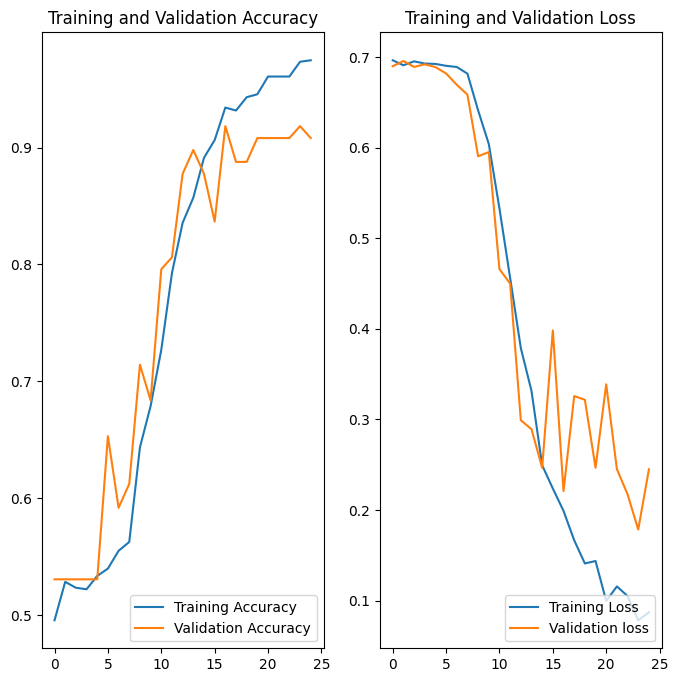

In [75]:
plt.figure(figsize=(8,8))

plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc,label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc,label='Validation Accuracy')

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss,label='Training Loss')
plt.plot(range(EPOCHS), val_loss,label='Validation loss')

plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

first Image to Predict
actual label: Accident
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted label: Accident


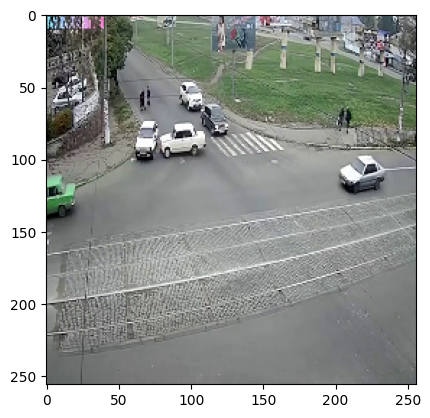

In [77]:
for images_batch,labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first Image to Predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("Predicted label:",class_names[np.argmax(batch_prediction[0])])

In [91]:
model.save("accident_detection.h5")

In [92]:
ls

accident_detection.h5


In [81]:
from IPython.display import FileLink

FileLink(r'accident_detection.h5')

/kaggle/working/accident_detection.h5

In [90]:
model_1 = tf.keras.models.load_model("accident_detection.h5")

In [97]:
from IPython.display import FileLink

FileLink(r'accident_detect.weights.h5')

/kaggle/working/accident_detect.weights.h5